#TUTORIAL: ADHOC IMAGE SEARCH
This tutorial give a short implementation for the idea of using semantic feature extracted from image for further searching. The semantic feature is used in this tutorial is image caption generated from an encoder-decoder model. For the encoder, Convolutional Neural Networks is employed to represent an input image as a feature vector (or tensor). For the decoder, a Recurrent Neural Network with Long-Short Term Memory cells is employed to decode visual feature to semantic textual feature using word embeding.

# Step 1 - Preparation
This step setups a connection between the Colab server to the Google Drive server (authenticated by your Google account). By this way, you can synchronize the computational machine with your personal data.

After that, to prepare for the semantic feature indexing step, please install *Whoosh* library. Then, we have a couple of code to check that your installation works well and learn how to index and query with a text dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Check GDrive connection
# NOTE THAT: You should change this path based on your real configuration
tutorial_path = '/content/drive/MyDrive/1. Learning/Information Retrieval/Visual Search/'
%cd '$tutorial_path'

/content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial


Verify that you alread install Whoosh lib sucessully after restart machine in runtime.

In [4]:
import os
from whoosh.index import create_in
from whoosh.fields import Schema, TEXT, ID
import sys

Now, it's time for deeper test the library. We use Whoosh to index a dataset of text files, prepared in the following directory: *'<tutorial_path\>/data/text/'*

All text file in this directory will be indexed and save in a folder named *indexdir*. This folder contains many indexes files which will be used later in the query stage.

In [5]:
def createSearchableData(root):
    '''
    Schema definition: title(name of file), path(as ID), content(indexed
    but not stored),textdata (stored text content)
    '''
    schema = Schema(title=TEXT(stored=True),path=ID(stored=True),\
              content=TEXT,textdata=TEXT(stored=True))
    if not os.path.exists("indexdir"):
        os.mkdir("indexdir")
 
    # Creating a index writer to add document as per schema
    ix = create_in("indexdir",schema)
    writer = ix.writer()
 
    filepaths = [os.path.join(root,i) for i in os.listdir(root)]
    for path in filepaths:
        fp = open(path,'r')
        print('Indexing ', path)
        text = fp.read()
        writer.add_document(title=path.split("/")[1], path=path, content=text, textdata=text)
        fp.close()
    print("Indexing finished!")
    writer.commit()

**Indexing stage**: point out the directory so that the engine could scan and index all text files.

In [6]:
root = tutorial_path + 'data/text'
createSearchableData(root)

Indexing  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/text/data1.txt
Indexing  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/text/data2.txt
Indexing  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/text/data3.txt
Indexing  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/text/data4.txt
Indexing  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/text/data5.txt
Indexing finished!


**Query Stage**:
 - define the index directory *''indexdir*
 - define the query string
 - preprocess the query string
 - search and show the result

In [7]:
from whoosh.qparser import QueryParser
from whoosh import scoring
from whoosh.index import open_dir

ix = open_dir("indexdir")
 
# query_str is query string
query_str = 'djokovic vô địch rome man utd'
query_str = query_str.replace(' ', ' OR ')
# Top 'n' documents as result
topN = int(10)
 
with ix.searcher(weighting=scoring.Frequency) as searcher:
    query = QueryParser("content", ix.schema).parse(query_str)
    print(query)
    results = searcher.search(query,limit=topN)
    print(len(results))
    for i in range(len(results)):
      print(' --------------- Rank #', i, '---------------')
      print(results[i]['title'])
      print(str(results[i].score))
      print(results[i]['textdata'])

(content:djokovic OR content:vô OR content:địch OR content:rome OR content:man OR content:utd)
3
 --------------- Rank # 0 ---------------
content
9.0
Cựu tiền đạo Man Utd Dwight Yorke lạc quan sau khi đội bóng cũ chiêu mộ Edinson Cavani trong ngày cuối kỳ chuyển nhượng hè 2020.

"Tất cả chúng tôi đều liên tưởng Edinson Cavani tới Zlatan Ibrahimovic bởi những gì cậu ấy có thể cống hiến Man Utd cũng như giúp đỡ các cầu thủ trẻ. Có Cavani, tôi không còn thấy lo lắng về hàng công Man Utd nữa", Dwight Yorke nói trên Sky Sports. "Tôi tin Man Utd đang có bộ ba tấn công tốt nhất Ngoại hạng Anh, sánh ngang Liverpool và Man City".
 --------------- Rank # 1 ---------------
content
8.0
Stefanos Tsitsipas suýt bị loại ở vòng một, nhưng có thể gây khó khăn cho Novak Djokovic ở bán kết Roland Garros, hôm nay 9/10.

* Tsitsipas - Djokovic: khoảng 23h00 thứ Sáu 9/10, giờ Hà Nội.

Tsitsipas đã thắng 14 set liên tiếp tại Roland Garros, còn Djokovic vừa thua set đầu trước Pablo Carreno Busta ở tứ kết. Ph

#Step 2 - Image captioning
In this step, we try to use a pretrained encoder-decoder model with CNN and LSTM to extract semantic features of an image. The caption extracted by the model will be used to index by Whoosh library.

Firstly, we load all images in the input director and normalize them using the parameters provided by the CNN model.

In [8]:
sys.path.append(tutorial_path)
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from model import EncoderCNN, DecoderRNN
from build_vocab import Vocabulary
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

Secondly, we load the pretrained models including encoder and decoder.

In [9]:
encoder_path = tutorial_path + 'models/encoder-5-3000.pkl'
decoder_path = tutorial_path +'models/decoder-5-3000.pkl'
vocab_path = tutorial_path + 'data/vocab.pkl'

# Model parameters (should be same as paramters in train.py)
embed_size  = 256
hidden_size = 512
num_layers = 1

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)
# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


<All keys matched successfully>

Thirdly, we build up a function for image captioning using loaded models.

In [10]:
def caption_image(image, encoder, decoder, vocab, transform):
    # Prepare an image
    image = load_image(image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    return sentence


It's time for testing an image in the *'data/image'* directory

In [11]:
caption_image(tutorial_path+'data/image/dog1.jpg', encoder, decoder, vocab, transform)

'<start> a dog is sitting on a green grass . <end>'

#Step 3 - Indexing semantic features

First, we inherit the code from Step 1 to index image using its caption generated by the model.

In [12]:
def createSearchableVisualData(root):
    '''
    Schema definition: title(name of file), path(as ID), content(indexed
    but not stored),textdata (stored text content)
    '''
    schema = Schema(title=TEXT(stored=True),path=ID(stored=True),\
              content=TEXT,textdata=TEXT(stored=True))
    if not os.path.exists("indexdir"):
        os.mkdir("indexdir")
 
    # Creating a index writer to add document as per schema
    ix = create_in("indexdir",schema)
    writer = ix.writer()
 
    filepaths = [os.path.join(root,i) for i in os.listdir(root)]
    for path in filepaths:
        
        print('Captioning ', path)
        text = caption_image(path, encoder, decoder, vocab, transform)
        print('Indexing ', text)
        writer.add_document(title=path.split("/")[-1], path=path, content=text, textdata=text)
    print("Indexing finished!")
    writer.commit()

Start indexing all images in the directory *'<tutorial_path\>/data/image'*

In [13]:
root = tutorial_path + 'data/image'
createSearchableVisualData(root)

Captioning  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/image/beach_and_girl.jpg
Indexing  <start> a man is flying a kite on a beach . <end>
Captioning  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/image/beach_and_girl2.jpg
Indexing  <start> a woman is holding a pink umbrella on a beach . <end>
Captioning  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/image/street_food2.jpg
Indexing  <start> a table with plates of food and a bowl of food . <end>
Captioning  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/image/dog.jpg
Indexing  <start> a dog is standing on a grass covered field . <end>
Captioning  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/image/dog1.jpg
Indexing  <start> a dog is sitting on a green grass . <end>
Captioning  /content/drive/MyDrive/1. Teaching/Information Retrieval/Tutorial/data/image/car.jpg
Indexing  <start> a black and white photo of a blac

To visualize the ranked list, we use HTML code. It should be skipped if you dont know web programming.

In [14]:
from IPython import display
import base64

def append_to_html(query, urls, scores):
  """Display a text query and the top result videos and scores."""
  html = ''
  html += '<h2>Input query: <i>{}</i> </h2><div>'.format(query)
  html += 'Results: <div>'
  html += '<table><tr>'
  for idx, score in enumerate(scores):
    html += '<th>Rank #{}, Score:{:.2f}</th>'.format(idx+1, score)
  html += '</tr><tr>'
  for i, url in enumerate(urls):
    html += '<td>'
    data_uri = base64.b64encode(open(url, 'rb').read()).decode('utf-8')
    html += '<img src="data:image/png;base64,{0}" height="224">'.format(data_uri)
    html += '</td>'
  html += '</tr></table></div></div>'
  return html

Finally, using a text query to search and show the retrieved results.

"Rank #1, Score:2.00","Rank #2, Score:2.00","Rank #3, Score:2.00","Rank #4, Score:1.00","Rank #5, Score:1.00","Rank #6, Score:1.00","Rank #7, Score:1.00","Rank #8, Score:1.00"
,,,,,,,

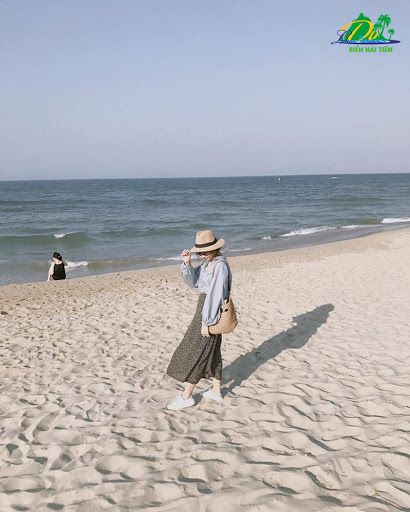
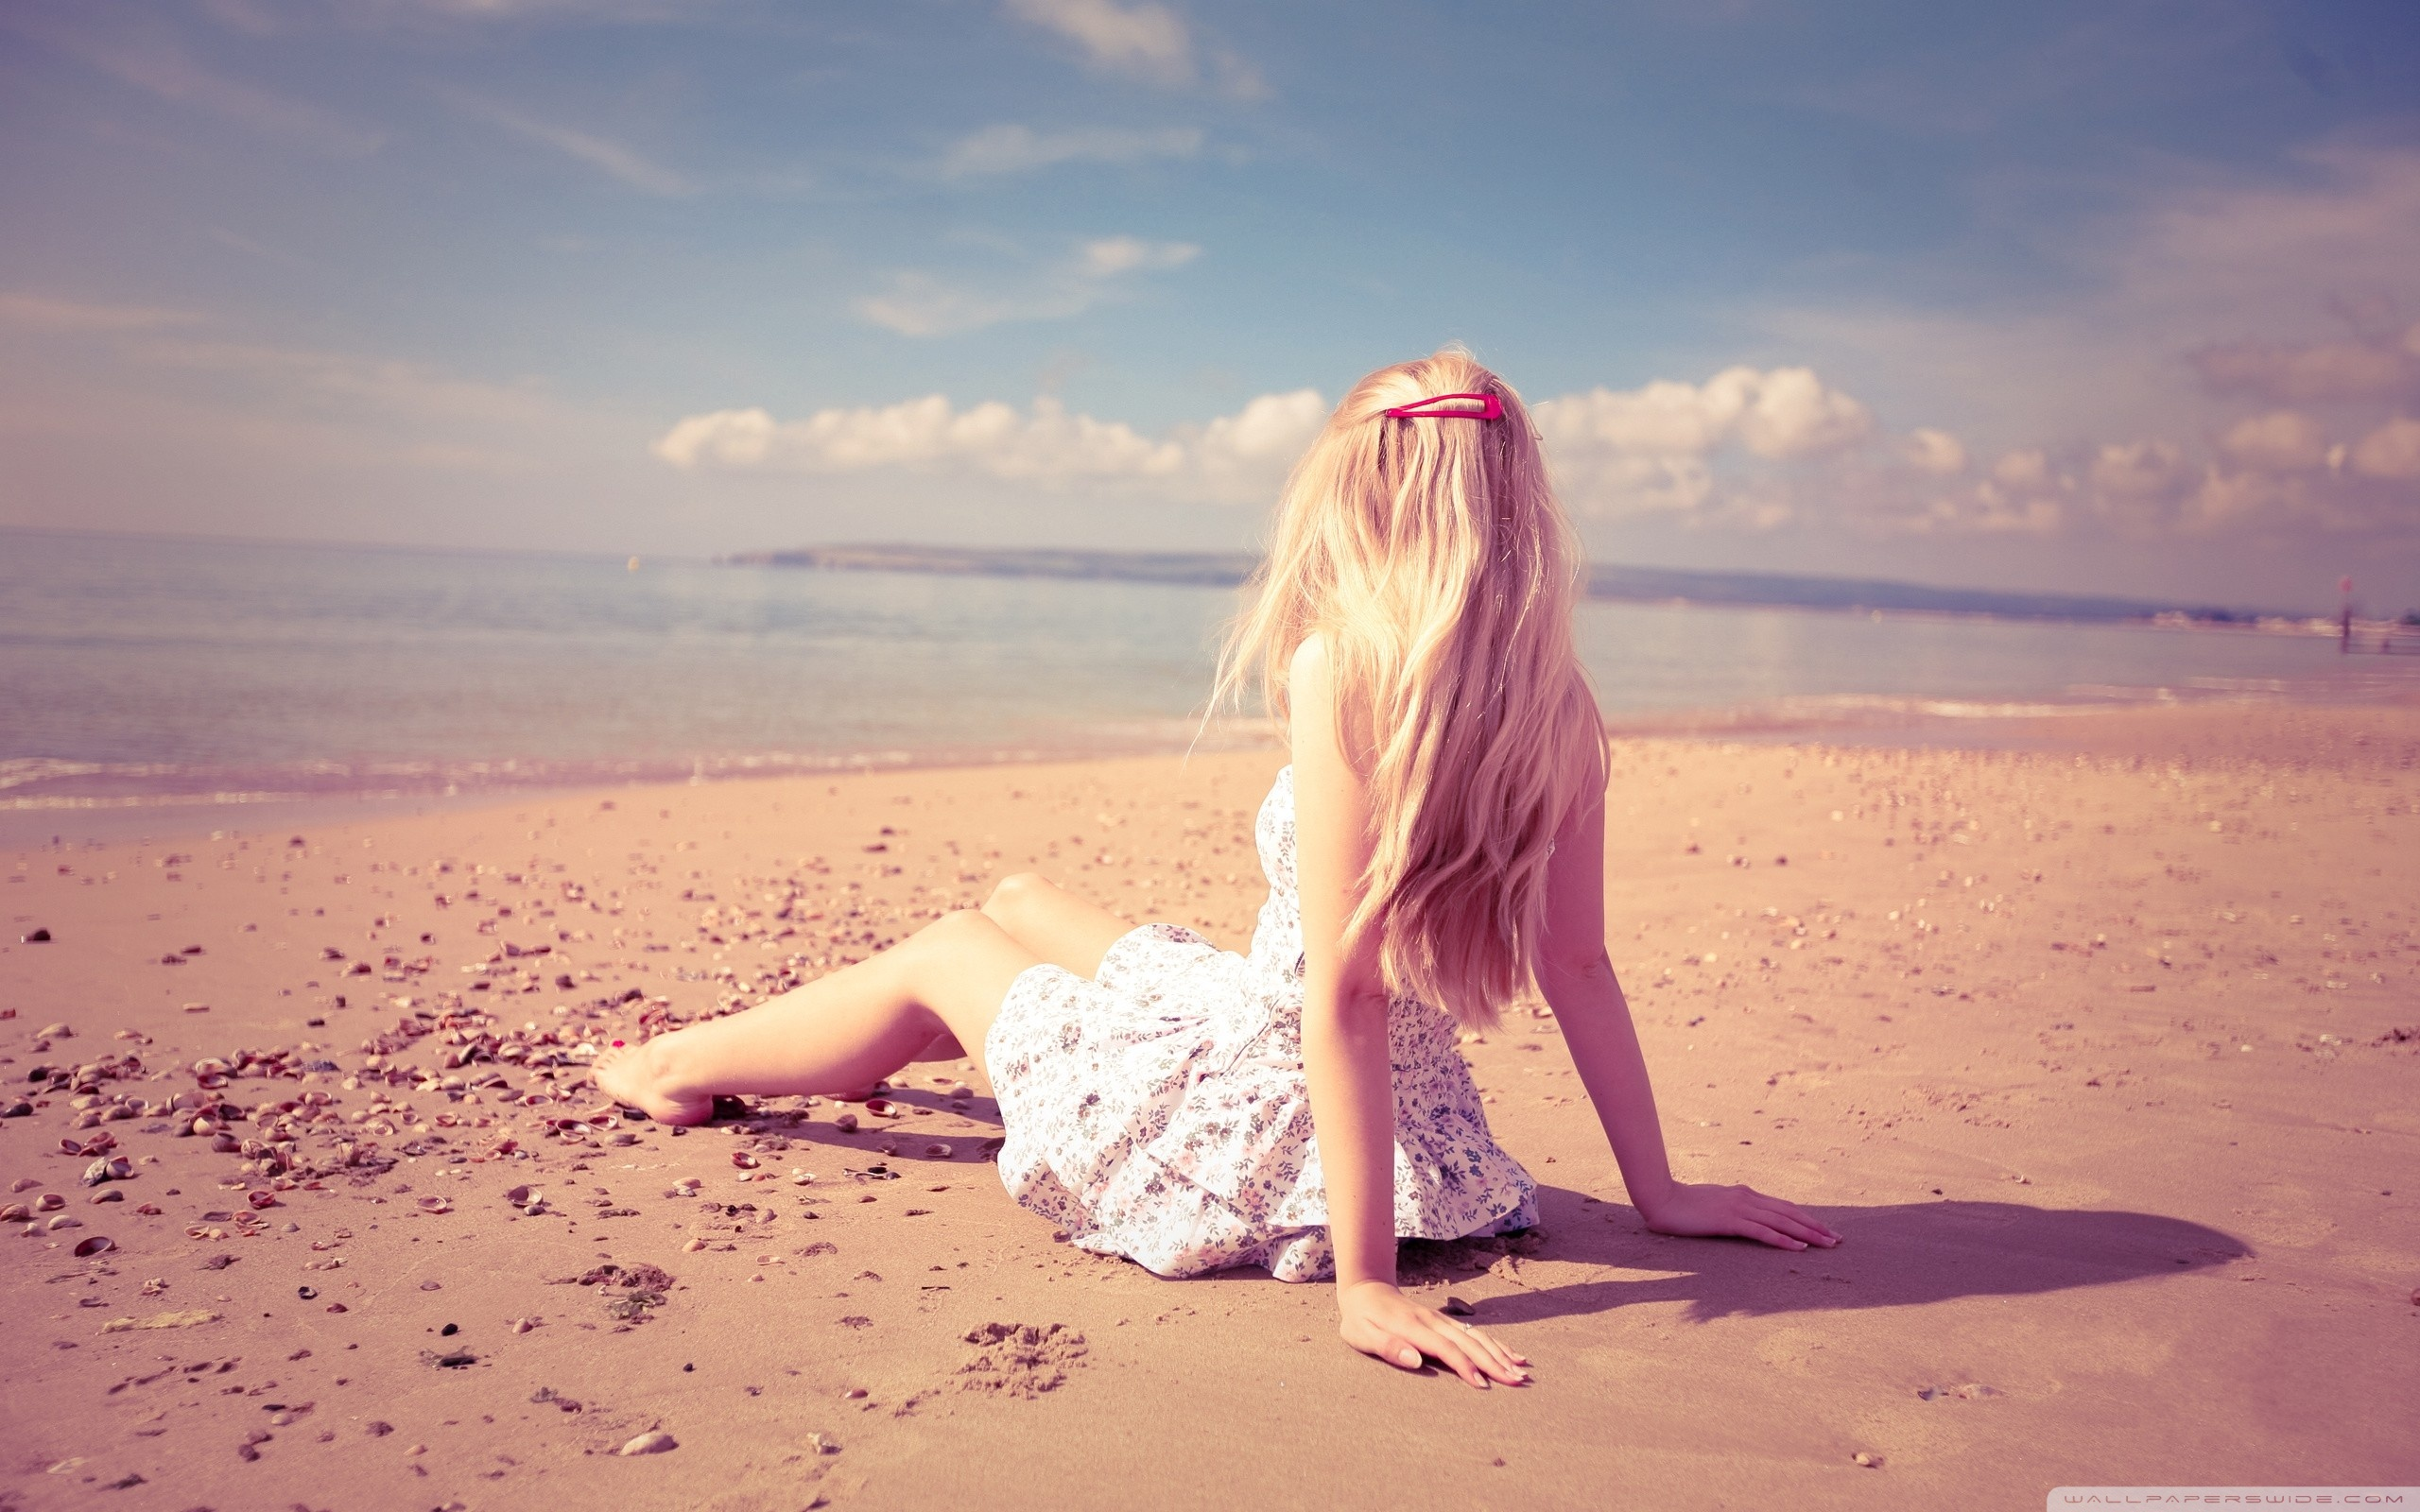
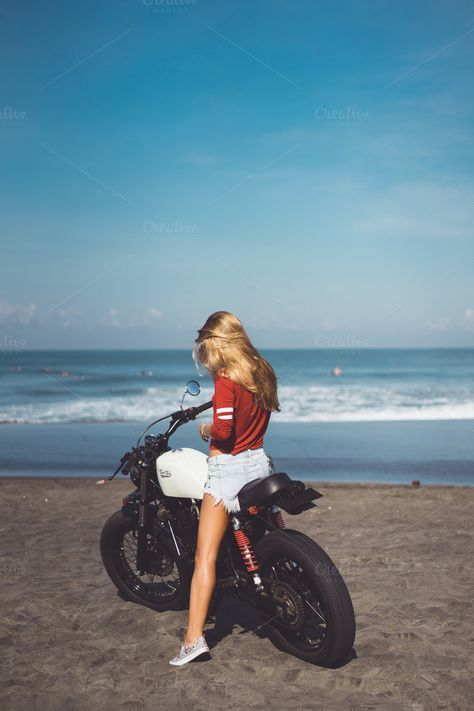
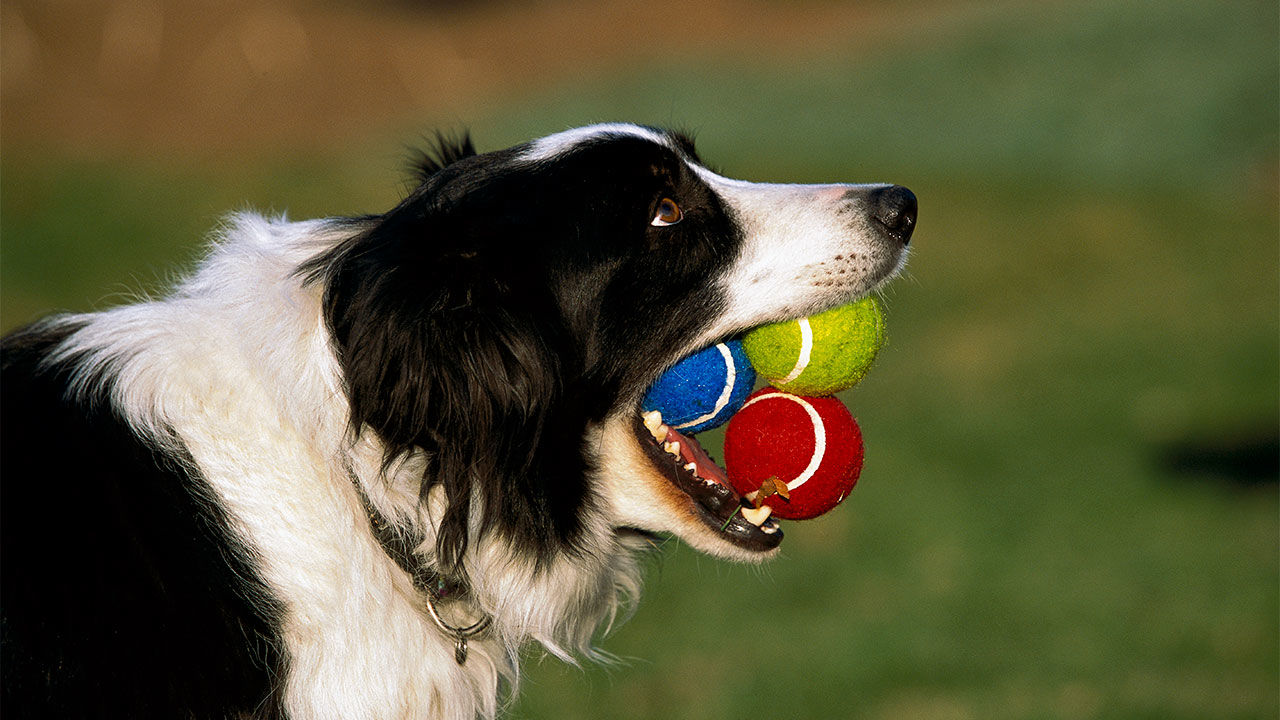
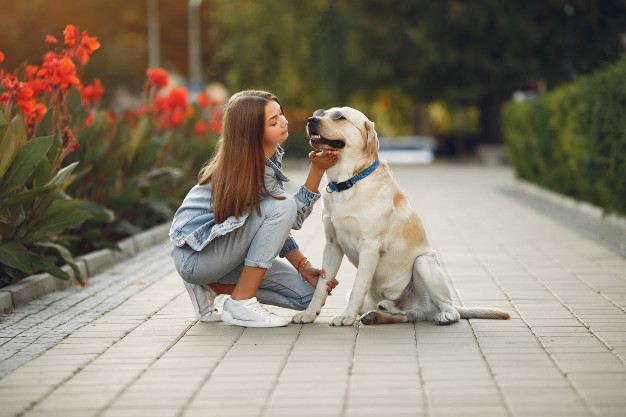
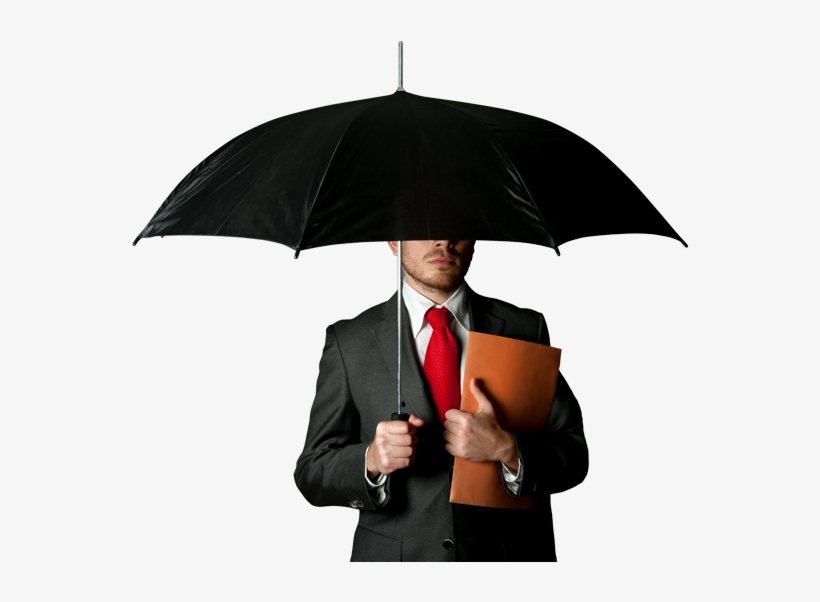
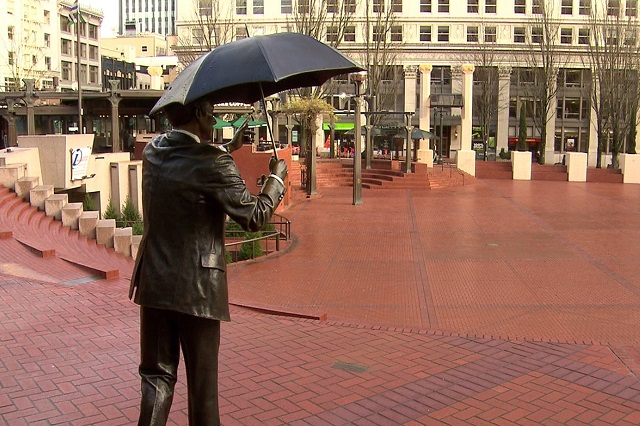
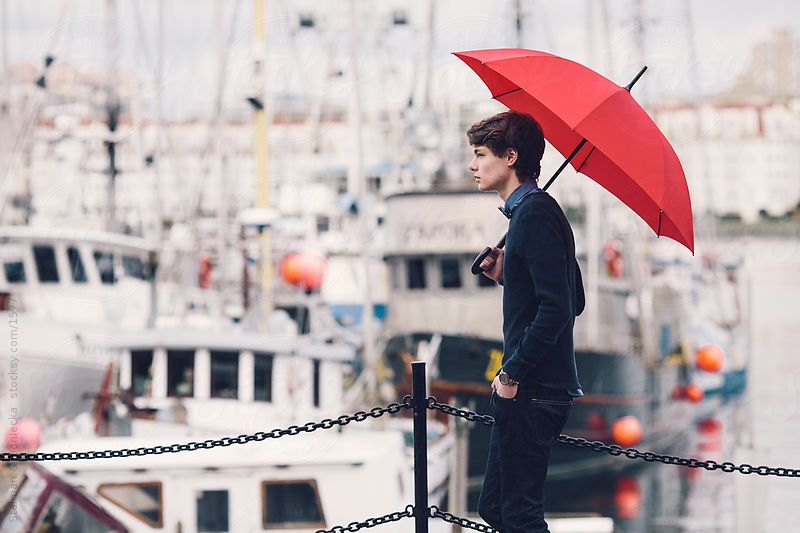

In [15]:
ix = open_dir("indexdir")
 
# query_str is query string
query_str = 'man woman sitting on a beach'
query_str = query_str.replace(' ', ' OR ')
# Top 'n' documents as result
topN = int(10)

with ix.searcher(weighting=scoring.Frequency) as searcher:
    query = QueryParser("content", ix.schema).parse(query_str)
    results = searcher.search(query,limit=topN)
    urls = []
    scores = []
    for i in range(len(results)):
      urls.append(results[i]['path'])
      scores.append(results[i].score)
    html = append_to_html(query_str, urls, scores)
display.HTML(html)